### Sentiment Analysis 

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Importing Libraries

In [2]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import statistics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.regularizers import l2

### Data Cleaning and Preprocessing

In [3]:
#Folder path for positive data
folder = '../data/pos'
pos_train_data=[]
pos_test_data=[]
neg_train_data=[]
neg_test_data=[]
y_train=[]
y_test=[]

# seperating train and test data while also assigning labels to the data
# Labels used are 0:neg and 1:pos as the activation function in the output layer used is sigmoid (range[0,1]) and loss function used is binary cross entropy
for file in os.listdir(folder):
    if any(re.search(f"cv{i:03d}", file) for i in range(0,700)):
        with open(os.path.join(folder, file), 'r') as f:
            content=f.read()
            pos_train_data.append(content)
            y_train.append(1)

    else:
        with open(os.path.join(folder, file), 'r') as f:
            content=f.read()
            pos_test_data.append(content)
            y_test.append(1)

#Folder path for negative data
folder='../data/neg'
for file in os.listdir(folder):
    if any(re.search(f"cv{i:03d}", file) for i in range(0,700)):
        with open(os.path.join(folder, file), 'r') as f:
            content=f.read()
            neg_train_data.append(content)
            y_train.append(0)
    else:
        with open(os.path.join(folder, file), 'r') as f:
            content=f.read()
            neg_test_data.append(content)
            y_test.append(0)


# Combining pos and neg data to get train and test data
X_train=pos_train_data + neg_train_data
X_test=pos_test_data + neg_test_data

X_train_c=[]
X_test_c=[]

# Data Cleaning
# Removing punctuations and numbers from the data
for t in X_train:
    t=re.sub(r'[^\w\s]', '', t.replace('_', ''))
    t = re.sub(r'\d+', '', t)
    X_train_c.append(t)

for t in X_test:
    t=re.sub(r'[^\w\s]', '', t.replace('_', ''))
    t = re.sub(r'\d+', '', t)
    X_test_c.append(t)


In [4]:
#  Creating a dataframe to represent the data with X and Y values (text and labels)
data_set=pd.DataFrame(X_train_c+X_test_c)
data_set.columns=['X']
Y=y_train+y_test
data_set.insert(1,"Y",Y)
data_set

,X,Y
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1
2,youve got mail works alot better than it deser...,1
3,jaws is a rare film that grabs your attenti...,1
4,moviemaking is a lot like being the general ma...,1
...,...,...
1995,if anything stigmata should be taken as a w...,0
1996,john boormans zardoz is a goofy cinematic de...,0
1997,the kids in the hall are an acquired taste \n...,0
1998,there was a time when john carpenter was a gre...,0


### Unique Words

In [5]:
# Unique words calculation
d=data_set['X']
text=' '.join(d)
count=len(set(text.split()))
print("No. of uniques words in the dataset:",count)

No. of uniques words in the dataset: 46787


### Histogram 

Average review length: 644.3465
Std deviation of review length: 284.9771




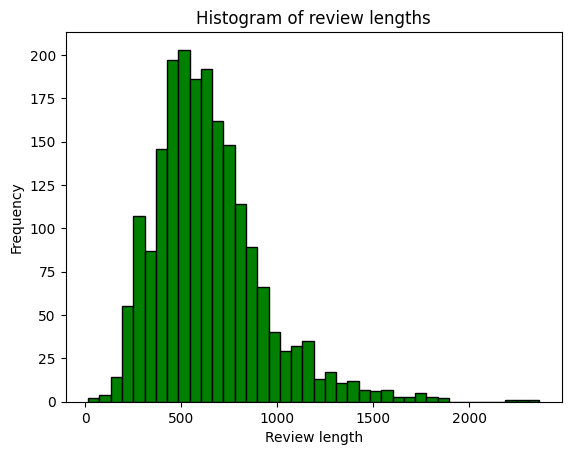

In [6]:
# Histogram of review lengths plotted and avg reveiew length and standard deviation of the review length is also calculated
review=data_set['X']
r_len=[]
for r in review:
    r_len.append(len(r.split()))
avg_review_len = np.mean(r_len)
stdev_review_len = np.std(r_len)
print("Average review length:",round(avg_review_len,4))
print("Std deviation of review length:",round(stdev_review_len,4))
print("\n")

plt.hist(r_len, bins=40,color='green',edgecolor='black')
plt.xlabel('Review length')
plt.ylabel('Frequency')
plt.title('Histogram of review lengths')
plt.show()

### Tokenization

In [7]:
# Using tokenizer to tokenize text doc
all_data=data_set['X']
t = Tokenizer()
t.fit_on_texts(X_train_c)
tokens_all = t.texts_to_sequences(all_data)
data_set.insert(2,"tokens",tokens_all)

### Threshold Calculation

In [8]:
# L value calculation
review=X_train_c
r_len=[]
for r in review:
    r_len.append(len(r.split()))
r=set(r_len)
r=sorted(r)
th_index=int(0.7*len(r))
th=r[th_index]
th

808

### zero padding and truncating

In [9]:
# zero padding and truncating
zp_tokens = pad_sequences(data_set['tokens'], maxlen=th, padding='post', truncating='post')
data_set['zp_tokens']=zp_tokens.tolist()
data_set

,X,Y,tokens,zp_tokens
0,films adapted from comic books have had plenty...,1,"[66, 3436, 31, 344, 1574, 32, 90, 1069, 4, 616...","[66, 3436, 31, 344, 1574, 32, 90, 1069, 4, 616..."
1,every now and then a movie comes along from a ...,1,"[149, 141, 3, 97, 2, 28, 200, 256, 31, 2, 1544...","[149, 141, 3, 97, 2, 28, 200, 256, 31, 2, 1544..."
2,youve got mail works alot better than it deser...,1,"[715, 287, 4181, 376, 10593, 155, 59, 9, 1168,...","[715, 287, 4181, 376, 10593, 155, 59, 9, 1168,..."
3,jaws is a rare film that grabs your attenti...,1,"[2677, 6, 2, 1520, 15, 8, 5604, 164, 565, 145,...","[2677, 6, 2, 1520, 15, 8, 5604, 164, 565, 145,..."
4,moviemaking is a lot like being the general ma...,1,"[5346, 6, 2, 207, 38, 112, 1, 835, 2680, 4, 24...","[5346, 6, 2, 207, 38, 112, 1, 835, 2680, 4, 24..."
...,...,...,...,...
1995,if anything stigmata should be taken as a w...,0,"[51, 230, 7828, 162, 23, 568, 10, 2, 2002, 338...","[51, 230, 7828, 162, 23, 568, 10, 2, 2002, 338..."
1996,john boormans zardoz is a goofy cinematic de...,0,"[196, 20985, 6, 2, 1994, 1111, 10119, 39, 8844...","[196, 20985, 6, 2, 1994, 1111, 10119, 39, 8844..."
1997,the kids in the hall are an acquired taste \n...,0,"[1, 390, 7, 1, 1530, 20, 24, 9758, 2394, 9, 88...","[1, 390, 7, 1, 1530, 20, 24, 9758, 2394, 9, 88..."
1998,there was a time when john carpenter was a gre...,0,"[52, 30, 2, 62, 43, 196, 2387, 30, 2, 123, 320...","[52, 30, 2, 62, 43, 196, 2387, 30, 2, 123, 320..."


### Word Embedding

In [10]:
# Word Embedding parameters as mentioned in the question
vocab_size = 5000
embedding_dim = 32
max_length = th
#  tokens having value greater than 5000 setting them to 0
token_data = data_set['zp_tokens'].tolist()
for index, token_seq in enumerate(token_data):
        token_data[index] = [i if i < vocab_size else 0 for i in token_seq]

In [11]:
# Train and Test Data for the model
train_X=token_data[:1400]
test_X=token_data[1400:]
train_X = np.array(train_X)
Y_train = np.array(y_train)
test_X=np.array(test_X)
Y_test=np.array(y_test)

In [12]:
# Accuracy dictionary to store as per model
accuracy={'Model':[],'Train accuracy':[],'Test accuracy':[]}

### Multi Layer Preceptron

In [13]:
#Multi Layer Preceptron
MLP = Sequential()
# Adding embedding layer as a part of the network; as it can allow the model to learn the embedding while training and optimize it accordingly
MLP.add(Embedding(input_dim=5000, output_dim=embedding_dim, input_length=max_length))
MLP.add(Flatten())
MLP.add(Dense(50, activation='relu'))
MLP.add(Dropout(0.2))
MLP.add(Dense(50, activation='relu'))
MLP.add(Dropout(0.5))
MLP.add(Dense(50, activation='relu'))
MLP.add(Dropout(0.5))
MLP.add(Dense(1, activation='sigmoid'))
MLP.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
MLP.fit(train_X, Y_train, epochs=2, batch_size=10,validation_data=(test_X,Y_test))

Epoch 1/2
140/140 [==============================] - 23s 140ms/step - loss: 0.6927 - accuracy: 0.5221 - val_loss: 0.6830 - val_accuracy: 0.5650
Epoch 2/2
140/140 [==============================] - 13s 91ms/step - loss: 0.6204 - accuracy: 0.6471 - val_loss: 0.6257 - val_accuracy: 0.6467


In [14]:
# Model evaluation to get train and test accuracies
loss_tr, accuracy_tr = MLP.evaluate(train_X, Y_train)
loss_tst,accuracy_tst = MLP.evaluate(test_X, Y_test)
print("Train Accuracy for MLP:",accuracy_tr)
print("Test Accuracy for MLP:",accuracy_tst)
accuracy['Model'].append('Multi Layer Perceptron')
accuracy['Train accuracy'].append(accuracy_tr)
accuracy['Test accuracy'].append(accuracy_tst)

19/19 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.6467
Train Accuracy for MLP: 0.9021428823471069
Test Accuracy for MLP: 0.6466666460037231


### Convolutional Neural Network

In [15]:
#Convolutional Neural Network
input_shape = (854, 32,)
CNN = Sequential()
# Adding embedding layer as a part of the network; as it can allow the model to learn the embedding while training and optimize it accordingly
CNN.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
# Adding kernel_regularizer(L2) to the network, as it would help with reducing the possibility of overfitting
CNN.add(Conv1D(filters=32, kernel_size=3,input_shape=input_shape,kernel_regularizer=l2(0.01)))
CNN.add(MaxPooling1D(pool_size=2, strides=2))
CNN.add(Flatten())
CNN.add(Dense(50, activation='relu'))
CNN.add(Dropout(0.2))
CNN.add(Dense(50, activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(50, activation='relu'))
CNN.add(Dropout(0.5))
CNN.add(Dense(1, activation='sigmoid'))
CNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
CNN.fit(np.array(train_X), np.array(y_train), epochs=5, batch_size=10, validation_data=(np.array(test_X),np.array(y_test)))

Epoch 1/5
140/140 [==============================] - 20s 124ms/step - loss: 0.8418 - accuracy: 0.5057 - val_loss: 0.7422 - val_accuracy: 0.5000
Epoch 2/5
140/140 [==============================] - 11s 80ms/step - loss: 0.7156 - accuracy: 0.5307 - val_loss: 0.6994 - val_accuracy: 0.5550
Epoch 3/5
140/140 [==============================] - 10s 69ms/step - loss: 0.7025 - accuracy: 0.5257 - val_loss: 0.6919 - val_accuracy: 0.5300
Epoch 4/5
140/140 [==============================] - 6s 45ms/step - loss: 0.6980 - accuracy: 0.5200 - val_loss: 0.6904 - val_accuracy: 0.5550
Epoch 5/5
140/140 [==============================] - 4s 32ms/step - loss: 0.6836 - accuracy: 0.5686 - val_loss: 0.6654 - val_accuracy: 0.6333


In [16]:
# Model evaluation to get train and test accuracies
loss_tr, accuracy_tr = CNN.evaluate(train_X, Y_train)
loss_tst,accuracy_tst = CNN.evaluate(test_X, Y_test)
print("Train Accuracy for CNN:",accuracy_tr)
print("Test Accuracy for CNN:",accuracy_tst)
accuracy['Model'].append('Convolutional Neural Network')
accuracy['Train accuracy'].append(accuracy_tr)
accuracy['Test accuracy'].append(accuracy_tst)

19/19 [==============================] - 0s 3ms/step - loss: 0.6654 - accuracy: 0.6333
Train Accuracy for CNN: 0.697857141494751
Test Accuracy for CNN: 0.6333333253860474


### LSTM

In [17]:
#  LSTM
LSTM_model = Sequential()
# Adding embedding layer as a part of the network; as it can allow the model to learn the embedding while training and optimize it accordingly
LSTM_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
# Adding kernel_regularizer(L2) to the network, as it would help with reducing the possibility of overfitting
LSTM_model.add(LSTM(256, input_shape=(input_shape), dropout=0.2,kernel_regularizer=l2(0.001)))
LSTM_model.add(Dense(256, activation='relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
LSTM_model.fit(np.array(train_X), np.array(y_train), epochs=15, batch_size=10, validation_data=(np.array(test_X),np.array(y_test)))

Epoch 1/15
140/140 [==============================] - 21s 131ms/step - loss: 0.7054 - accuracy: 0.5364 - val_loss: 0.6903 - val_accuracy: 0.5483
Epoch 2/15
140/140 [==============================] - 15s 111ms/step - loss: 0.7565 - accuracy: 0.5450 - val_loss: 0.6866 - val_accuracy: 0.5483
Epoch 3/15
140/140 [==============================] - 9s 67ms/step - loss: 0.6764 - accuracy: 0.5743 - val_loss: 0.6933 - val_accuracy: 0.5517
Epoch 4/15
140/140 [==============================] - 8s 60ms/step - loss: 0.6377 - accuracy: 0.5993 - val_loss: 0.7348 - val_accuracy: 0.5400
Epoch 5/15
140/140 [==============================] - 9s 61ms/step - loss: 0.6127 - accuracy: 0.6229 - val_loss: 0.8375 - val_accuracy: 0.5450
Epoch 6/15
140/140 [==============================] - 7s 54ms/step - loss: 0.5950 - accuracy: 0.6236 - val_loss: 0.7953 - val_accuracy: 0.5450
Epoch 7/15
140/140 [==============================] - 8s 57ms/step - loss: 0.5747 - accuracy: 0.6229 - val_loss: 0.7785 - val_accuracy: 0.

In [18]:
# Model evaluation to get train and test accuracies
loss_tr, accuracy_tr = LSTM_model.evaluate(train_X, Y_train)
loss_tst,accuracy_tst = LSTM_model.evaluate(test_X, Y_test)
print("Train Accuracy for LSTM:",accuracy_tr)
print("Test Accuracy for LSTM:",accuracy_tst)
accuracy['Model'].append('LSTM')
accuracy['Train accuracy'].append(accuracy_tr)
accuracy['Test accuracy'].append(accuracy_tst)

19/19 [==============================] - 0s 17ms/step - loss: 0.8345 - accuracy: 0.5483
Train Accuracy for LSTM: 0.6292856931686401
Test Accuracy for LSTM: 0.5483333468437195


### Accuracies

In [19]:
data_accuracy=pd.DataFrame(accuracy)
data_accuracy

,Model,Train accuracy,Test accuracy
0,Multi Layer Perceptron,0.902143,0.646667
1,Convolutional Neural Network,0.697857,0.633333
2,LSTM,0.629286,0.548333


### Reference

#### 1]https://keras.io/api/layers/core_layers/embedding/
#### 2]https://www.baeldung.com/cs/neural-nets-embedding-layers#:~:text=In%20summary%2C%20we%20use%20embedding,is%20a%20specific%20input%20feature.
#### 3]https://keras.io/api/layers/regularizers/